Notebook to explore other approaches, such as using a neural network to predict the target variable.

# Testing Random Forrest

In [2]:
%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

import pandas as pd
from util import util
import numpy as np
import os
data_folder = os.path.join('..', 'data')
file_name = "DataForModel"

In [3]:
data = util.load_data(data_folder, file_name)
data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,...,Diff_shots_on_target_attempted,Diff_shots_on_target_allowed,Diff_shots_attempted,Diff_shots_allowed,Diff_corners_awarded,Diff_corners_conceded,Diff_fouls_commited,Diff_fouls_suffered,Diff_yellow_cards,Diff_red_cards
0,E0,2005-09-17,Aston Villa,Tottenham,1.0,1.0,0506,-25.173204,0.412832,0.245673,...,-9,10,-14,16,20,18,-13,9,-6,0
1,E0,2005-09-17,Portsmouth,Birmingham,1.0,1.0,0506,6.045620,0.468846,0.222236,...,4,-2,4,-4,0,13,6,17,1,0
2,E0,2005-09-17,Sunderland,West Brom,1.0,1.0,0506,-32.751187,0.399092,0.251422,...,9,-1,-4,8,5,0,-1,-21,-3,1
3,E0,2005-09-18,Blackburn,Newcastle,0.0,3.0,0506,34.014412,0.517707,0.201792,...,1,-13,7,-15,5,-14,0,-2,1,0
4,E0,2005-09-18,Man City,Bolton,0.0,1.0,0506,33.333649,0.516538,0.202282,...,3,3,-8,18,-4,2,-6,-17,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33998,E3,2024-04-27,Gillingham,Doncaster,2.0,2.0,2324,-111.203962,0.303611,0.218419,...,-16,12,-18,28,1,6,6,-19,-4,0
33999,E3,2024-04-27,Milton Keynes Dons,Sutton,4.0,4.0,2324,147.385429,0.692702,0.128574,...,2,-9,13,-23,-1,5,-29,10,-6,0
34000,E3,2024-04-27,Salford,Harrogate,2.0,2.0,2324,-47.482218,0.372310,0.262627,...,-7,-7,7,-18,-8,-4,17,6,9,2
34001,E3,2024-04-27,Swindon,Morecambe,3.0,3.0,2324,-33.608246,0.397536,0.252073,...,12,9,13,17,-13,-8,7,6,-5,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34003 entries, 0 to 34002
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Div                             34003 non-null  object        
 1   Date                            34003 non-null  datetime64[ns]
 2   HomeTeam                        34003 non-null  object        
 3   AwayTeam                        34003 non-null  object        
 4   FTHG                            34003 non-null  float64       
 5   FTAG                            34003 non-null  float64       
 6   Season                          34003 non-null  object        
 7   ELO diff                        34003 non-null  float64       
 8   Home_prob_ELO                   34003 non-null  float64       
 9   Draw_prob_ELO                   34003 non-null  float64       
 10  Away_prob_ELO                   34003 non-null  float64       
 11  Di

In [5]:
data_with_div = data.copy()

### Handling Non-numeric Data
The first step is to convert the non-numeric data into numeric data. This can be done using the `LabelEncoder` class from the `sklearn.preprocessing` module. 

In [6]:
# Removing div column:



In [7]:
from sklearn.preprocessing import LabelEncoder
data = data.copy()
label_encoder = LabelEncoder()

#Convert Date to numerial values
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day
data["DayOfWeek"] = data[
    "Date"
].dt.dayofweek  # Optional

# Drop the original Date column as it’s no longer needed
data = data.drop(columns=["Date"])

In [8]:
# One hot encoding of hometeam and awayteam
data = pd.get_dummies(
    data, columns=["HomeTeam", "AwayTeam"]
)

In [9]:
print(data.dtypes)

Div                  object
FTHG                float64
FTAG                float64
Season               object
ELO diff            float64
                     ...   
AwayTeam_Wolves        bool
AwayTeam_Wrexham       bool
AwayTeam_Wycombe       bool
AwayTeam_Yeovil        bool
AwayTeam_York          bool
Length: 250, dtype: object


### Defining target variable

We want to predict the outcome. To create a numeric representation for this, we will create a columns called Outcome which has a vlue of 1 for home wins, 0 for draws and -1 for away wins. This corresponds to the way a strength difference is represented by positive or negative numbers depending on if it is in favour of the home or away team

In [10]:
# Add a new column Outcome which is 1 if HomeTeam wins, 0 if draw, -1 if AwayTeam wins
data["Outcome"] = data.apply(
    lambda row: (
        1 if row["FTHG"] > row["FTAG"] else (0 if row["FTHG"] == row["FTAG"] else -1)
    ),
    axis=1,
)

In [11]:
data

,Div,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,Away_prob_ELO,Diff_goals_scored,Diff_goals_conceded,...,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,AwayTeam_Wrexham,AwayTeam_Wycombe,AwayTeam_Yeovil,AwayTeam_York,Outcome
0,E0,1.0,1.0,0506,-25.173204,0.412832,0.245673,0.341496,0,6,...,False,False,False,False,False,False,False,False,False,0
1,E0,1.0,1.0,0506,6.045620,0.468846,0.222236,0.308918,0,-1,...,False,False,False,False,False,False,False,False,False,0
2,E0,1.0,1.0,0506,-32.751187,0.399092,0.251422,0.349487,-3,-1,...,False,True,False,False,False,False,False,False,False,0
3,E0,0.0,3.0,0506,34.014412,0.517707,0.201792,0.280500,2,-2,...,False,False,False,False,False,False,False,False,False,-1
4,E0,0.0,1.0,0506,33.333649,0.516538,0.202282,0.281180,1,0,...,False,False,False,False,False,False,False,False,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33998,E3,2.0,2.0,2324,-111.203962,0.303611,0.218419,0.477970,-12,4,...,False,False,False,False,False,False,False,False,False,0
33999,E3,4.0,4.0,2324,147.385429,0.692702,0.128574,0.178724,6,1,...,False,False,False,False,False,False,False,False,False,0
34000,E3,2.0,2.0,2324,-47.482218,0.372310,0.262627,0.365063,-7,-4,...,False,False,False,False,False,False,False,False,False,0
34001,E3,3.0,3.0,2324,-33.608246,0.397536,0.252073,0.350392,4,0,...,False,False,False,False,False,False,False,False,False,0


In [12]:
print("Outcome distribution:")
print(data["Outcome"].value_counts())

Outcome distribution:
Outcome
 1    14814
-1    10241
 0     8948
Name: count, dtype: int64


In [13]:
data_with_div = data.copy()
data.drop(columns="Div", inplace=True)

### Split data into training and testing sets

Now, we will split the data into traing and test sets to properly test our model. The X-daataset will contain all our engeineered features that describe the match before it is played. The y-dataset will contain the outcome. We will use a 80/20 split, as this is the most normal. Football probably has evolved over the course of the 20 years, so to not get caught in only using "old" data to only test predictions on "new" data, we will use a randomized sampling

In [14]:
X = data.copy().drop(
    columns=["Outcome", "FTHG", "FTAG", "Season"]
)  # Drop columns not needed for prediction
y = data.copy()["Outcome"]

In [15]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We use a Random Forest to predict the outcomes

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(
    "Classification Report:\n",
    classification_report(
        y_test, y_pred, target_names=["Away Win", "Draw", "Home Win"]
    ),
)

Accuracy: 0.45875606528451696
Classification Report:
               precision    recall  f1-score   support

    Away Win       0.42      0.39      0.40      2026
        Draw       0.34      0.05      0.08      1866
    Home Win       0.48      0.77      0.59      2909

    accuracy                           0.46      6801
   macro avg       0.41      0.40      0.36      6801
weighted avg       0.42      0.46      0.40      6801



Even with more sophisticated models we see the accuracy is still pretty low. However, by looking at the recall for each of the outcomes we see that the model has a really hard time predicting draws. This is a recurring pattern in many papers on predicting outcomes of football matches. A reason for this is the randomness involved in sport and the small margin between draws and a win for one team. Teams only need one goal more to win, and goals could often be a result of randomness, by mistakes or other more human factors. 

With this in mind, we change our focus. Instead, we now try to predict an expected goal difference for each match. This will be used to predict home or away wins where we find them certain. High uncertainty is connected with draws, which we will now avoid to predict.

### AUC

As we can see the model gives an accuracy of 46% which is not very good. Instead we want to looak at the AUC socres for the model.

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Make predictions and probability estimates on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Binarize the y_test labels for multi-class AUC calculation
y_test_binarized = label_binarize(
    y_test, classes=[-1, 0, 1]
)  # Adjust class labels as needed

# Calculate AUC for each class separately (one-vs-rest)
auc_per_class = roc_auc_score(y_test_binarized, y_pred_proba, average=None)

# Compute the macro-average AUC
auc_macro = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(
    "Classification Report:\n",
    classification_report(
        y_test, y_pred, target_names=["Away Win", "Draw", "Home Win"]
    ),
)

# Print AUC for each class
class_names = ["Away Win", "Draw", "Home Win"]
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {class_names[i]}: {auc:.2f}")

# Print the macro-average AUC
print("AUC (macro-average):", auc_macro)

Accuracy: 0.45875606528451696
Classification Report:
               precision    recall  f1-score   support

    Away Win       0.42      0.39      0.40      2026
        Draw       0.34      0.05      0.08      1866
    Home Win       0.48      0.77      0.59      2909

    accuracy                           0.46      6801
   macro avg       0.41      0.40      0.36      6801
weighted avg       0.42      0.46      0.40      6801

AUC for Away Win: 0.64
AUC for Draw: 0.54
AUC for Home Win: 0.63
AUC (macro-average): 0.6015213974712745


We see that is 0.64 for home wins, 0.63 for away wins and 0.54 for draws. This is not very good, but it is better than the accuracy score.

### Changing the dataset

One reason for this poor performace is that we have data from four different leauges in the same dataset. It could be the case that it is diffucult to predict the outcome of a match in one league based on data from another league. We further try to only use data from the English Premier League to see if this improves the model.

In [19]:

data_premiere_leauge = data_with_div[data_with_div["Div"] == "E0"]
data_premiere_leauge

,Div,FTHG,FTAG,Season,ELO diff,Home_prob_ELO,Draw_prob_ELO,Away_prob_ELO,Diff_goals_scored,Diff_goals_conceded,...,AwayTeam_Watford,AwayTeam_West Brom,AwayTeam_West Ham,AwayTeam_Wigan,AwayTeam_Wolves,AwayTeam_Wrexham,AwayTeam_Wycombe,AwayTeam_Yeovil,AwayTeam_York,Outcome
0,E0,1.0,1.0,0506,-25.173204,0.412832,0.245673,0.341496,0,6,...,False,False,False,False,False,False,False,False,False,0
1,E0,1.0,1.0,0506,6.045620,0.468846,0.222236,0.308918,0,-1,...,False,False,False,False,False,False,False,False,False,0
2,E0,1.0,1.0,0506,-32.751187,0.399092,0.251422,0.349487,-3,-1,...,False,True,False,False,False,False,False,False,False,0
3,E0,0.0,3.0,0506,34.014412,0.517707,0.201792,0.280500,2,-2,...,False,False,False,False,False,False,False,False,False,-1
4,E0,0.0,1.0,0506,33.333649,0.516538,0.202282,0.281180,1,0,...,False,False,False,False,False,False,False,False,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32523,E0,5.0,0.0,2324,-90.969466,0.324565,0.233493,0.441941,5,-3,...,False,False,False,False,False,False,False,False,False,1
32524,E0,2.0,0.0,2324,243.886381,0.803305,0.082298,0.114397,8,-2,...,False,False,False,False,True,False,False,False,False,1
32525,E0,2.0,4.0,2324,-127.316525,0.287220,0.206627,0.506153,1,8,...,False,False,False,False,False,False,False,False,False,-1
32526,E0,3.0,1.0,2324,315.526105,0.862550,0.057509,0.079941,10,-14,...,False,False,True,False,False,False,False,False,False,1


In [20]:
from sklearn.preprocessing import LabelEncoder
# Remove Div
data_premiere_leauge.drop(columns="Div", inplace=True)


/var/folders/91/krf3259915q7p7c3dwrtcbg80000gn/T/ipykernel_53396/2660918130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_premiere_leauge.drop(columns="Div", inplace=True)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X = data_premiere_leauge.copy().drop(
    columns=["Outcome", "FTHG", "FTAG", "Season"]
)  # Drop columns not needed for prediction
y = data_premiere_leauge.copy()["Outcome"]


# Split data_premiere_leauge into training and test sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Initialize the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Make predictions and probability estimates on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Binarize the y_test labels for multi-class AUC calculation
y_test_binarized = label_binarize(
    y_test, classes=[-1, 0, 1]
)  # Adjust class labels as needed

# Calculate AUC for each class separately (one-vs-rest)
auc_per_class = roc_auc_score(y_test_binarized, y_pred_proba, average=None)

# Compute the macro-average AUC
auc_macro = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(
    "Classification Report:\n",
    classification_report(
        y_test, y_pred, target_names=["Away Win", "Draw", "Home Win"]
    ),
)

# Print AUC for each class
class_names = ["Away Win", "Draw", "Home Win"]
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {class_names[i]}: {auc:.2f}")

# Print the macro-average AUC
print(f"AUC (macro-average): {auc_macro:.2f}")

Accuracy: 0.57
Classification Report:
               precision    recall  f1-score   support

    Away Win       0.52      0.55      0.54       368
        Draw       0.35      0.07      0.12       268
    Home Win       0.61      0.80      0.69       615

    accuracy                           0.57      1251
   macro avg       0.50      0.48      0.45      1251
weighted avg       0.53      0.57      0.52      1251

AUC for Away Win: 0.75
AUC for Draw: 0.59
AUC for Home Win: 0.74
AUC (macro-average): 0.69


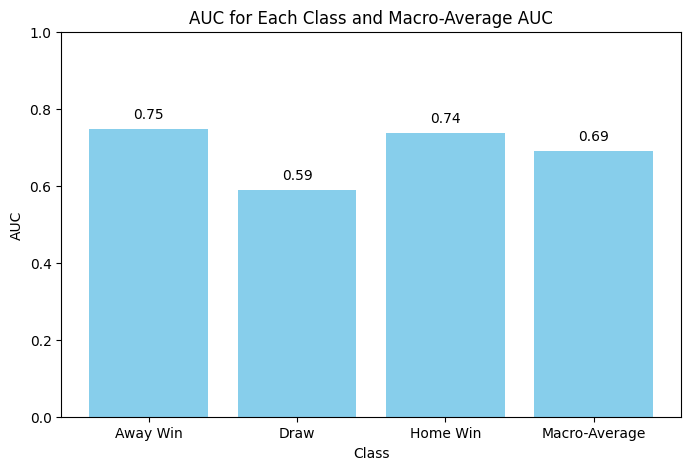

In [23]:
util.plot_auc_per_class(auc_per_class, class_names, auc_macro)

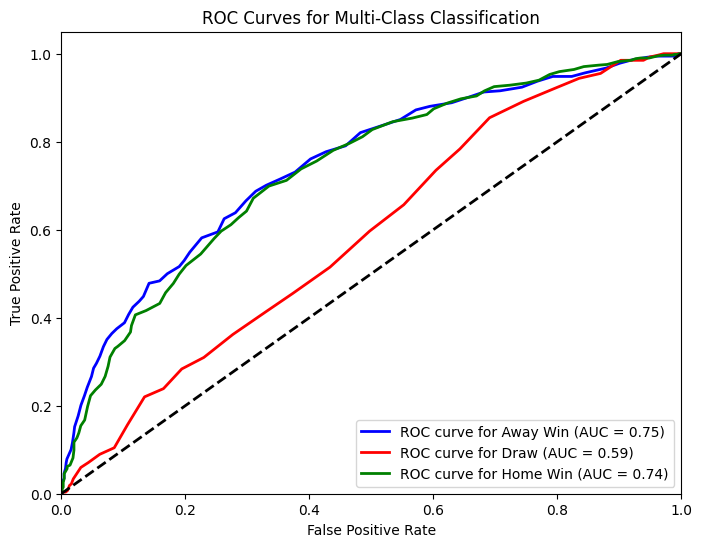

In [24]:
util.plot_multi_class_roc(
    y_test, y_pred_proba, classes=[-1, 0, 1], class_names=class_names
)

A big improvement! We see that AUC is 0.74 for home wins, 0.75 for away wins and 0.58 for draws. Still there is a issue with predicting draws, but the model is much better at predicting home and away wins. 

### Hyperparameter tuning

GridSearch

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Define the parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Set up Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc_ovr",
    n_jobs=-1,
    verbose=2,
)

# Fit Grid Search on the training data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model_grid = grid_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_

Using Random Search

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import numpy as np

# Define the parameter distribution
param_dist = {
    "n_estimators": [int(x) for x in np.linspace(start=50, stop=200, num=5)],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Set up Random Search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="roc_auc_ovr",
    n_jobs=-1,
    random_state=42,
    verbose=2,
)

# Fit Random Search on the training data
random_search.fit(X_train, y_train)

# Get the best model from random search
best_model_random_search = random_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=125; total time=   1.0s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=125; total time=   1.0s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=125; total time=   1.1s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=125; total time=   1.1s
[CV] END max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=12

Evaluating the best model

#### GridSearch model

In [29]:
# Make predictions and probability estimates on the test set using the best model
y_pred = best_model_grid.predict(X_test)
y_pred_proba = best_model_grid.predict_proba(X_test)

# Binarize the y_test labels for multi-class AUC calculation
y_test_binarized = label_binarize(
    y_test, classes=[-1, 0, 1]
)  # Adjust class labels as needed

# Calculate AUC for each class separately (one-vs-rest)
auc_per_class = roc_auc_score(y_test_binarized, y_pred_proba, average=None)

# Compute the macro-average AUC
auc_macro = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(
    "Classification Report:\n",
    classification_report(
        y_test, y_pred, target_names=["Away Win", "Draw", "Home Win"]
    ),
)

# Print AUC for each class
class_names = ["Away Win", "Draw", "Home Win"]
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {class_names[i]}: {auc:.2f}")

# Print the macro-average AUC
print(f"AUC (macro-average): {auc_macro:.2f}")

Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

    Away Win       0.54      0.55      0.55       368
        Draw       0.00      0.00      0.00       268
    Home Win       0.60      0.86      0.71       615

    accuracy                           0.58      1251
   macro avg       0.38      0.47      0.42      1251
weighted avg       0.45      0.58      0.51      1251

AUC for Away Win: 0.75
AUC for Draw: 0.60
AUC for Home Win: 0.74
AUC (macro-average): 0.70


#### Random Search model

In [30]:
# Make predictions and probability estimates on the test set using the best model
y_pred = best_model_random_search.predict(X_test)
y_pred_proba = best_model_random_search.predict_proba(X_test)

# Binarize the y_test labels for multi-class AUC calculation
y_test_binarized = label_binarize(
    y_test, classes=[-1, 0, 1]
)  # Adjust class labels as needed

# Calculate AUC for each class separately (one-vs-rest)
auc_per_class = roc_auc_score(y_test_binarized, y_pred_proba, average=None)

# Compute the macro-average AUC
auc_macro = roc_auc_score(y_test_binarized, y_pred_proba, average="macro")

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(
    "Classification Report:\n",
    classification_report(
        y_test, y_pred, target_names=["Away Win", "Draw", "Home Win"]
    ),
)

# Print AUC for each class
class_names = ["Away Win", "Draw", "Home Win"]
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {class_names[i]}: {auc:.2f}")

# Print the macro-average AUC
print(f"AUC (macro-average): {auc_macro:.2f}")

Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

    Away Win       0.53      0.54      0.54       368
        Draw       1.00      0.00      0.01       268
    Home Win       0.60      0.86      0.71       615

    accuracy                           0.58      1251
   macro avg       0.71      0.47      0.42      1251
weighted avg       0.67      0.58      0.51      1251

AUC for Away Win: 0.75
AUC for Draw: 0.60
AUC for Home Win: 0.74
AUC (macro-average): 0.70


This was not a much better result. AUC for draw is now 0.60 (improvement of 0.01 ), but the AUC for home and away wins are still the same.